### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import yfinance as yf

### Logistic Regression Class

In [2]:
class LogisticRegression:
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def cost_function(self, X, y, weights):
        z = np.dot(X, weights)
        predict_1 = y * np.log(self.sigmoid(z))
        predict_0 = (1 - y) * np.log(1 - self.sigmoid(z))
        return -np.sum(predict_1 + predict_0) / len(X)

    def fit(self, X, y, epochs=25, lr=0.05):
        loss = []
        weights = np.random.rand(X.shape[1])
        N = len(X)

        for _ in range(epochs):
            y_hat = self.sigmoid(np.dot(X, weights))
            weights -= lr * np.dot(X.T, y_hat - y) / N
            loss.append(self.cost_function(X, y, weights))

        self.weights = weights
        self.loss = loss

    def predict(self, X):
        z = np.dot(X, self.weights)
        return [1 if i > 0.5 else 0 for i in self.sigmoid(z)]

### Implement Standard Scaler

In [3]:
class CustomStandardScaler:
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        return self

    def transform(self, X):
        return (X - self.mean_) / self.std_

    def fit_transform(self, X):
        return self.fit(X).transform(X)

### Function to fetch stock data using yfinance

In [4]:
def get_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data

### Function to calculate prior probabilities

In [5]:
def calculate_prior(y):
    classes = sorted(np.unique(y))
    prior = []
    for c in classes:
        prior.append(np.sum(y == c) / len(y))
    return prior

### Function to calculate likelihood using Gaussian distribution

In [6]:
def calculate_likelihood_gaussian(X, feat_val, label):
    mean, std = np.mean(X[label]), np.std(X[label])
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-((feat_val - mean) ** 2) / (2 * std ** 2))
    return p_x_given_y

### Function to calculate likelihood using Categorical distribution

In [7]:

def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

### Naive Bayes classification using Gaussian model

In [8]:
def naive_bayes_gaussian(X_train, y_train, X_test):
    prior = calculate_prior(y_train)
    labels = np.unique(y_train)
    
    y_pred = []

    for x in X_test:
        likelihood = [1] * len(labels)

        for j, label in enumerate(labels):
            for i in range(X_train.shape[1]):
                likelihood[j] *= calculate_likelihood_gaussian(X_train[:, i], x[i], y_train == label)

        post_prob = [1] * len(labels)

        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        y_pred.append(labels[np.argmax(post_prob)])

    return np.array(y_pred)

### Categorical Naive Bayes classification

In [9]:
def naive_bayes_categorical(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    labels = sorted(list(df[Y].unique()))
    
    # calculate prior
    prior = calculate_prior(labels)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))
    return np.array(Y_pred)

### Fetch actual stock data using yfinance

In [10]:
# We can yfinance api to get ticker details or we can use downloaded dataset
# stock_symbol = 'AMZN'
# start_date = '2022-12-01'
# end_date = '2023-12-07'
# stock_data = get_stock_data(stock_symbol, start_date, end_date)
stock_data = pd.read_csv("AMZN_5Yrs.csv")

### Visualize Stock Price Movements

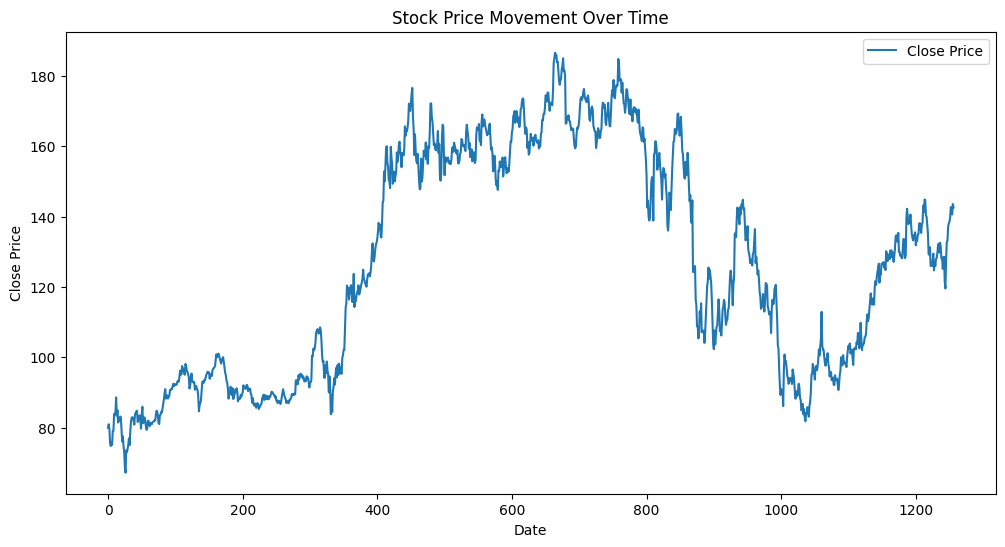

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label='Close Price')
plt.title('Stock Price Movement Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### Function to calculate RSI

In [12]:
def calculate_rsi(close_prices, window=14):
    price_diff = close_prices.diff(1)
    gain = price_diff.where(price_diff > 0, 0)
    loss = -price_diff.where(price_diff < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

### Add features (e.g., Simple Moving Average - SMA)

In [13]:
# Add features to stock_data
stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['EMA_12'] = stock_data['Close'].ewm(span=12, adjust=False).mean()
stock_data['RSI'] = calculate_rsi(stock_data['Close'])

### Label price movement

In [14]:
stock_data['Price_Up'] = np.where(stock_data['Close'].shift(-1) > stock_data['Close'], 1, 0)

### Drop NaN values after feature engineering

In [15]:
stock_data = stock_data.dropna()

### Define features and target

In [16]:
features = ['Close', 'SMA_20', 'EMA_12', 'RSI']
target = 'Price_Up'

### Visualize feature engineered data

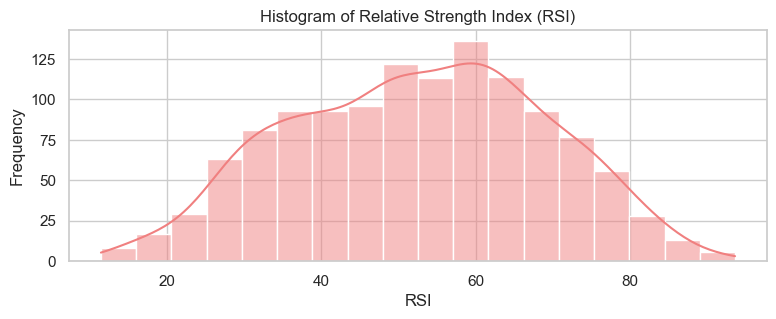

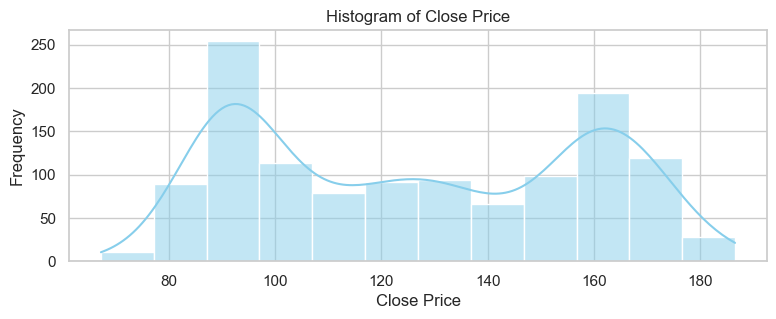

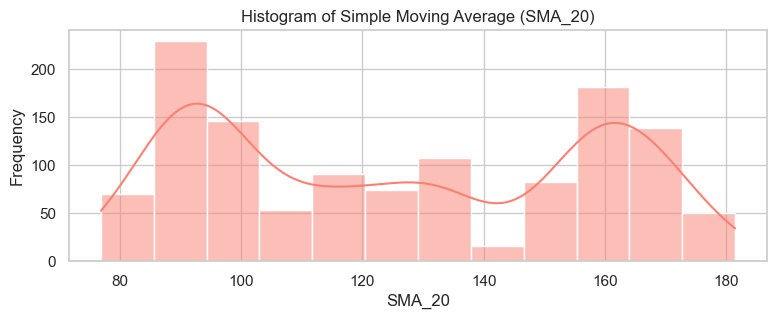

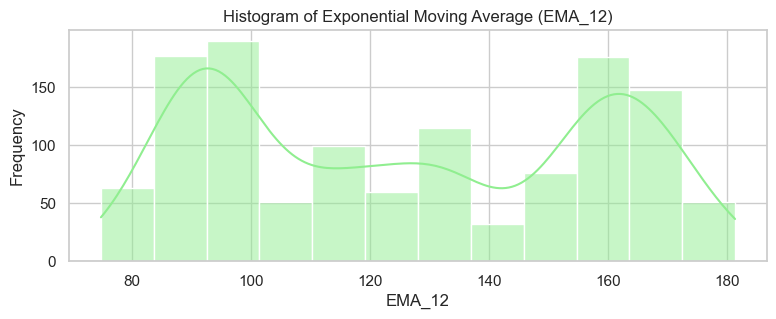

C:\Users\laksh\AppData\Local\Temp\ipykernel_26988\421800533.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Price_Up', data=stock_data, palette='viridis')


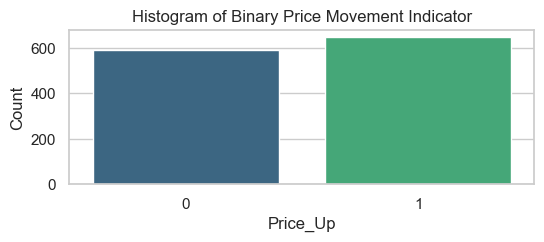

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for better visualization
sns.set(style="whitegrid")


# Plot histogram for 'RSI'
plt.figure(figsize=(9, 3))
sns.histplot(stock_data['RSI'], kde=True, color='lightcoral')
plt.title('Histogram of Relative Strength Index (RSI)')
plt.xlabel('RSI')
plt.ylabel('Frequency')
plt.show()


# Plot histogram for 'Close'
plt.figure(figsize=(9, 3))
sns.histplot(stock_data['Close'], kde=True, color='skyblue')
plt.title('Histogram of Close Price')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for 'SMA_20'
plt.figure(figsize=(9, 3))
sns.histplot(stock_data['SMA_20'], kde=True, color='salmon')
plt.title('Histogram of Simple Moving Average (SMA_20)')
plt.xlabel('SMA_20')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for 'EMA_12'
plt.figure(figsize=(9, 3))
sns.histplot(stock_data['EMA_12'], kde=True, color='lightgreen')
plt.title('Histogram of Exponential Moving Average (EMA_12)')
plt.xlabel('EMA_12')
plt.ylabel('Frequency')
plt.show()

# Plot histogram for 'Price_Up'
plt.figure(figsize=(6, 2))
sns.countplot(x='Price_Up', data=stock_data, palette='viridis')
plt.title('Histogram of Binary Price Movement Indicator')
plt.xlabel('Price_Up')
plt.ylabel('Count')
plt.show()


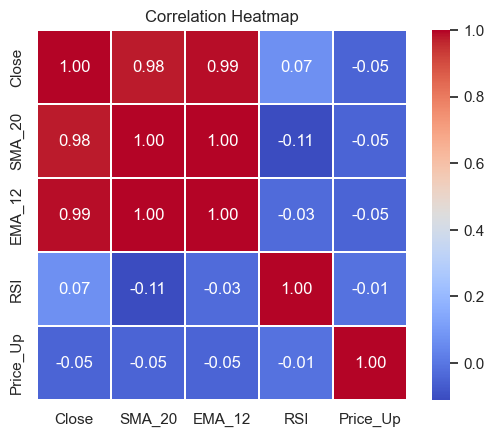

In [18]:
# Correlation Heatmap without GDP
correlation_matrix = stock_data[['Close', 'SMA_20', 'EMA_12', 'RSI', 'Price_Up']].corr()

# sns.heatmap(correlation_matrix, vmax=1, vmin=-.5, cmap='coolwarm', square=True, linewidths=.2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=.2)
plt.title('Correlation Heatmap')
plt.show()

### Split data into training and testing sets

In [19]:
X = stock_data[features].values
y = stock_data[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train and predict using Gaussian Naive Bayes

In [20]:
y_pred_nb = naive_bayes_gaussian(X_train, y_train, X_test)

### Normalize features

In [21]:
# Normalize features
scaler = CustomStandardScaler()
X_train_lr = scaler.fit_transform(X_train)
X_test_lr = scaler.transform(X_test)

### Train logistic regression model

In [22]:
model = LogisticRegression()
model.fit(X_train_lr, y_train)

### Make logistic regression predictions

In [23]:
y_pred_lr = model.predict(X_test_lr)

### Evaluate Naive Bayes model

In [24]:
print("Gaussian Naive Bayes - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))
print("Gaussian Naive Bayes - F1 Score:", f1_score(y_test, y_pred_nb))

Gaussian Naive Bayes - Confusion Matrix:
[[43 81]
 [36 88]]
Gaussian Naive Bayes - F1 Score: 0.6006825938566553


### Evaluate logistic regression model

In [25]:
print("Logistic Regression - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("Logistic Regression - F1 Score:", f1_score(y_test, y_pred_lr))

Logistic Regression - Confusion Matrix:
[[64 60]
 [68 56]]
Logistic Regression - F1 Score: 0.4666666666666667


In [26]:
# Convert continuous features to Categorical features
stock_data["cat_mean_close"] = pd.cut(stock_data["Close"].values, bins=10, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
stock_data["cat_mean_sma"] = pd.cut(stock_data["SMA_20"].values, bins=10, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
stock_data["cat_mean_ema"] = pd.cut(stock_data["EMA_12"].values, bins=10, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
stock_data["cat_mean_rsi"] = pd.cut(stock_data["RSI"].values, bins=10, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


stock_data.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_20,EMA_12,RSI,Price_Up,cat_mean_close,cat_mean_sma,cat_mean_ema,cat_mean_rsi
1247,2023-10-31,132.750000,133.570007,131.710007,133.089996,133.089996,51589400,128.397499,128.347818,51.590099,1,5,4,5,4
1248,2023-11-01,133.960007,137.350006,133.710007,137.000000,137.000000,61529400,128.897499,129.678923,55.426444,1,5,4,5,5
1249,2023-11-02,138.729996,138.809998,136.470001,138.070007,138.070007,52236700,129.503000,130.969859,59.961519,1,5,5,5,5
1250,2023-11-03,138.990005,139.490005,137.449997,138.600006,138.600006,44007200,130.035000,132.143728,57.691336,1,5,5,5,5
1251,2023-11-06,138.759995,140.729996,138.360001,139.740005,139.740005,44970400,130.609000,133.312386,60.497598,1,6,5,5,5
1252,2023-11-07,140.550003,143.369995,140.500000,142.710007,142.710007,53553500,131.270501,134.758174,68.682734,0,6,5,5,6
1253,2023-11-08,142.970001,143.119995,141.220001,142.080002,142.080002,44521700,131.783001,135.884609,67.369230,0,6,5,5,6
1254,2023-11-09,142.020004,142.649994,139.839996,140.600006,140.600006,36235400,132.196501,136.610055,70.502266,1,6,5,5,7
1255,2023-11-10,140.460007,143.649994,139.910004,143.559998,143.559998,49287800,132.885001,137.679277,71.683675,0,6,5,5,7
1256,2023-11-13,142.080002,143.229996,140.669998,142.589996,142.589996,35609400,133.387001,138.434772,68.378305,0,6,5,5,6


### Train Categorical Model

In [27]:

#stock_data = stock_data.drop(columns=["Close", "SMA_20", "EMA_12", "RSI"])
stock_data = stock_data[["cat_mean_close", "cat_mean_sma", "cat_mean_ema", "cat_mean_rsi", "Price_Up"]]

# Split data into training and testing sets for Categorical Naive Bayes
from sklearn.model_selection import train_test_split
train_cat, test_cat = train_test_split(stock_data, test_size=.2, random_state=41)

X_test_cat = train_cat.iloc[:,:-1].values
Y_test_cat = train_cat.iloc[:,-1].values
Y_pred_cat = naive_bayes_categorical(train_cat, X=X_test_cat, Y="Price_Up")

### Test Categorical Model

In [28]:
from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test_cat, Y_pred_cat))
print(f1_score(Y_test_cat, Y_pred_cat))

[[280 188]
 [256 266]]
0.5450819672131147
